<a href="https://colab.research.google.com/github/m-tabish/FER2013/blob/main/FER2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libraries

In [1]:
!pip install kaggle tensorflow pandas numpy scikit-learn graphviz visualkeras --quiet


# Import libraries

In [25]:
import os
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

# Set up kaggle (Sometimes need to run more than one time)


In [4]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path

# === STEP 1: Set Kaggle credentials as environment variables ===
os.environ['KAGGLE_USERNAME'] = "mtabish111"
os.environ['KAGGLE_KEY'] = "783de401ee61591142e17dcc6700c505"

# === STEP 2: Initialize and Authenticate Kaggle API ===
api= ""
try:
    api = KaggleApi()
    api.authenticate()
    print("Kaggle API authenticated successfully using environment variables.")
except IOError as e:
    # This will catch the error if the environment variables are not set correctly.
    print(f"Authentication failed: {e}")
    print("Please ensure your KAGGLE_USERNAME and KAGGLE_KEY environment variables are set correctly.")


Kaggle API authenticated successfully using environment variables.


# Download the dataset and unzip




In [5]:
dataset_slug = 'msambare/fer2013'
destination_path = Path('fer2013_data')

# Create the destination directory if it doesn't exist
destination_path.mkdir(parents=True, exist_ok=True)

# Download the dataset to the specified destination
print(f"Downloading dataset '{dataset_slug}' to '{destination_path}'...")
api.dataset_download_files(dataset_slug, path=destination_path, unzip=True)
print("Download complete.")

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
Download complete.


 # Data Preparation & Augmentation


In [20]:
IMG_SIZE = 48
BATCH_SIZE = 64
train_dir = "fer2013_data/train"
test_dir = "fer2013_data/test"

# 1. Create a single generator for both training and validation
#    and add the validation_split argument.
train_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # Reserve 20% of the training data for validation
)

# The test data generator remains separate and does not need a split.
test_datagen = ImageDataGenerator(rescale=1.0/255)

# 2. Create the training generator using the 'training' subset
train_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset='training' # Specify this is the training subset
)

# 3. Create the validation generator using the 'validation' subset
validation_generator = train_val_datagen.flow_from_directory(
    train_dir, # Use the same directory as the training generator
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    subset='validation' # Specify this is the validation subset
)

# 4. The test generator is created from the separate test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    class_mode="categorical"
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Viewing training images from dataset

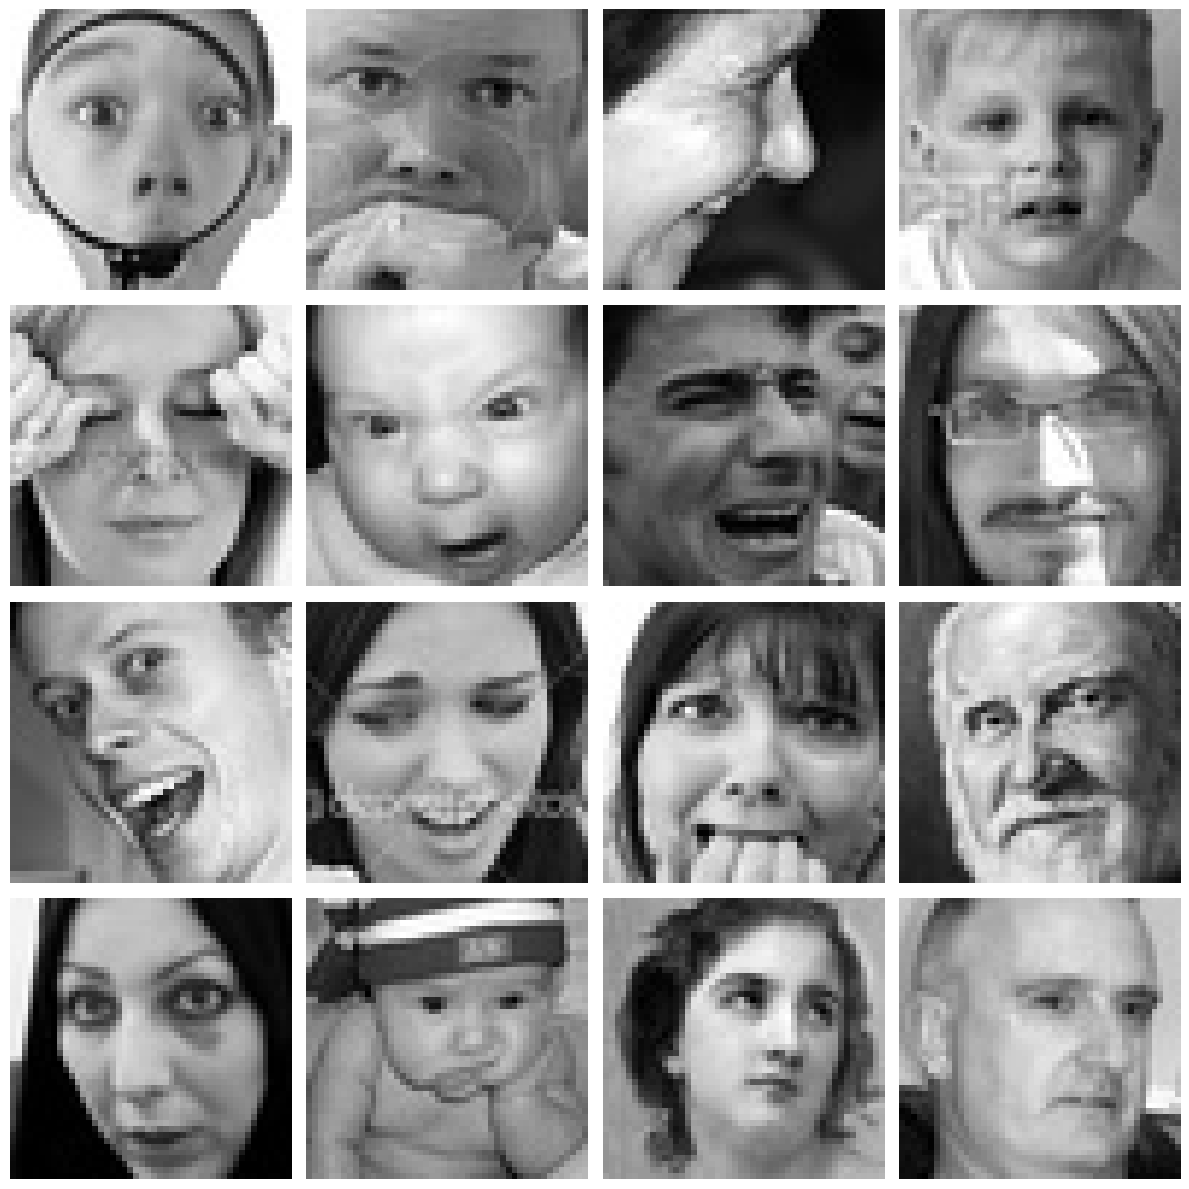

In [7]:
plt.style.use('ggplot')

# Get a batch of images and labels from the train_generator
images, labels = next(train_generator)

plt.figure(figsize=(12, 12))
for i in range(16):  # Displaying the first 16 images
    plt.subplot(4, 4, i + 1)
    # images[i] is expected to have shape (48, 48, 1) for grayscale
    plt.imshow(images[i].reshape((48, 48)), cmap="gray")
    plt.axis('off')
    plt.tight_layout()

plt.show()

# Print how many samples are in dataset

In [8]:
print("Train samples:", train_generator.samples)
print("Test samples:", test_generator.samples)

Train samples: 28709
Test samples: 7178


# Define CNN Model

In [11]:
# Image parameters
img_height = 48
img_width = 48
batch_size = 64


model = Sequential([

    # --- Block 1 ---
    # Input: 48x48x1 -> Output: 48x48x32
    Conv2D(32, (3,3), padding='same', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    Activation('relu'), # Apply activation after batch norm

    # Input: 48x48x32 -> Output: 24x24x32
    MaxPooling2D(pool_size=(2,2)), # Pool after the first block

    # --- Block 2 ---
    # Input: 24x24x32 -> Output: 24x24x64
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Input: 24x24x64 -> Output: 12x12x64
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # --- Block 3 ---
    # Input: 12x12x64 -> Output: 12x12x128
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    # Input: 12x12x128 -> Output: 6x6x128
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # --- Classifier Head ---
    Flatten(), # Flattens the 6x6x128 feature map

    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5), # Strong dropout for the dense layer

    Dense(train_generator.num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,935 (2.61 MB)

 Trainable params: 684,231 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

# Callback function for Plateau

In [12]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',   # Metric to watch
    patience=3,           # Number of epochs with no improvement before reducing
    factor=0.5,           # Multiply learning rate by this factor
    min_lr=1e-7,          # Lower bound for the learning rate
    verbose =1            # Print messages when LR changes
)

# Early Stopping
  

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',       # What to monitor
    patience=5,               # Stop after 5 epochs of no improvement
    restore_best_weights=True # Roll back to best model
)

# Training

In [15]:

EPOCHS = 50

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks =[lr_reduction, early_stop]
)



Epoch 1/50
447/449 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2063 - loss: 2.3043

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.2066 - loss: 2.3031 - val_accuracy: 0.3091 - val_loss: 1.8962 - learning_rate: 1.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.3189 - loss: 1.8584 - val_accuracy: 0.4244 - val_loss: 1.4929 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.3576 - loss: 1.7138 - val_accuracy: 0.4466 - val_loss: 1.4458 - learning_rate: 1.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3850 - loss: 1.6247 - val_accuracy: 0.4629 - val_loss: 1.3996 - learning_rate: 1.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.4062 - loss: 1.5615 - val_accuracy: 0.4668 - val_loss: 1.3877 - learning_rate: 1.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4281 - loss: 1.5066 - val_accuracy: 0.4911 - val_loss: 1.3418 - learning_rate: 1.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accurac

# Metrics : Accuracy, Precision, Recall, F1-score

In [16]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

# Compile with metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Use categorical_crossentropy for multi-class
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score
    ]
)

# Classification Report

 4/90 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


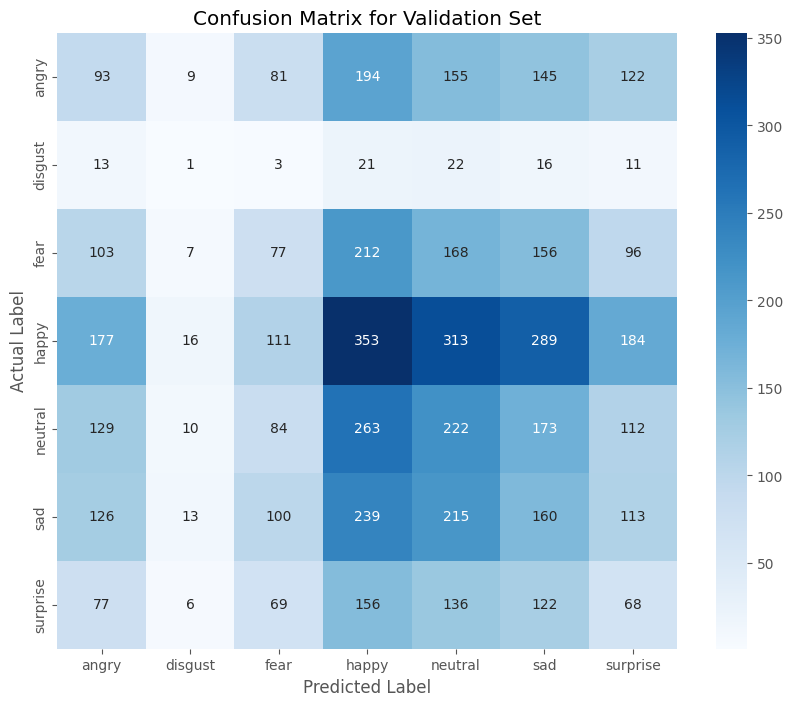

Classification Report for Validation Set

              precision    recall  f1-score   support

       angry       0.13      0.12      0.12       799
     disgust       0.02      0.01      0.01        87
        fear       0.15      0.09      0.11       819
       happy       0.25      0.24      0.25      1443
     neutral       0.18      0.22      0.20       993
         sad       0.15      0.17      0.16       966
    surprise       0.10      0.11      0.10       634

    accuracy                           0.17      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.17      0.17      5741



In [21]:
# 1. Get the true labels from the validation generator
# The .classes attribute gives the class index for each sample in order.
validation_labels = validation_generator.classes

# 2. Get the model's predictions for the validation set
# It's good practice to reset the generator before predicting
validation_generator.reset()
pred_probs = model.predict(validation_generator)
# Convert prediction probabilities to class labels
validation_pred_labels = np.argmax(pred_probs, axis=1)

# 3. Create the Confusion Matrix
cm = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(validation_generator.class_indices.keys())

# 4. Plot the confusion matrix for a more visual analysis
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Print the Classification Report
# This provides precision, recall, and f1-score for each class.
print("Classification Report for Validation Set\n")
print(classification_report(validation_labels, validation_pred_labels, target_names=class_names))

# Visualizing the model

In [37]:
# prompt: Write me a code to interactivaly visualize the Neural Network architecture of the above model

# Visualize the model architecture using visualkeras
# visualkeras.layered_view(model, legend=True)

# Alternatively, visualize using plot_model (requires pydot and graphviz)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# Saving the model plot in ./results
plt.savefig("results/model_plot.png")
plt.show()



<Figure size 640x480 with 0 Axes>

# Saving the Model

In [26]:
if not os.path.exists('./results'):
   os.mkdir('results')

model.save("results/emotion_model.keras")
print("Model saved successfully!")

Model saved successfully!


# Plotting the graphs (Accuracy/Loss Curves Visualization)

### Plot the train and validation loss

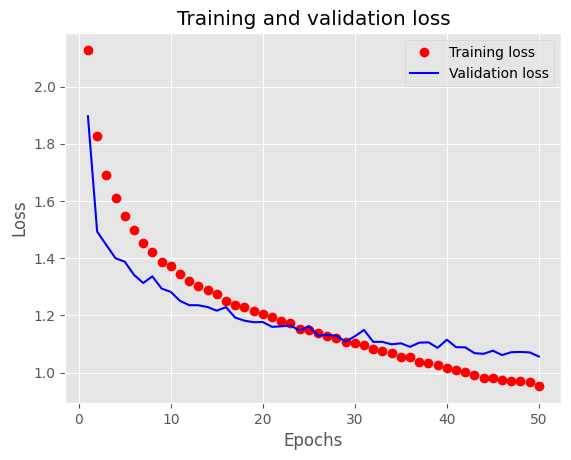

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("results/training_validation_loss.png")
plt.show()



### Plot the train and validation accuracy

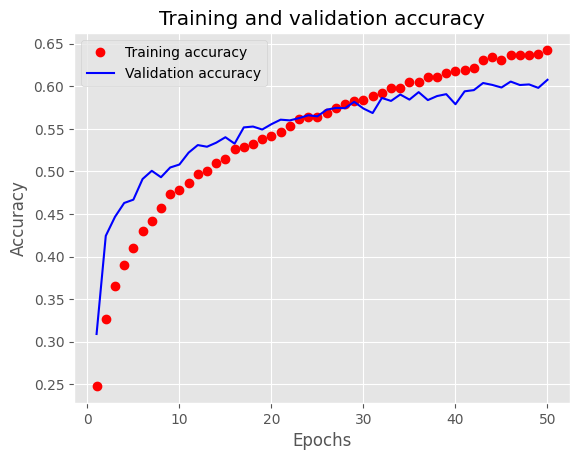

In [40]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("results/training_validation_accuracy.png")
plt.show()

# Converting results to zip for download

In [38]:
import shutil
# ====================
#  ZIP RESULTS
# ====================
shutil.make_archive("results", 'zip', "results")
print("✅ Training complete. Results saved to results.zip")

✅ Training complete. Results saved to results.zip
